In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import awswrangler as wr


In [5]:
from datetime import datetime

In [2]:
os.chdir('../../..')

# Reading

In [3]:
file_alldata = 'Outputs/comparacion/results/all_data_result_{}.csv'

In [4]:
df_emerg_filter = pd.read_csv('Outputs/comparacion/atenciones_filtradas.csv')

In [6]:
df_emerg_filter['id_sini'] = list(range(0, df_emerg_filter.shape[0]))
df_emerg_filter['cast_fecha_hora'] = pd.to_datetime(df_emerg_filter['fecha_hora_de_apertura'])

df_emerg_filter['periodo_YMD'] = df_emerg_filter.apply(lambda x: str(x.cast_fecha_hora.year) + str(x.cast_fecha_hora.month) + str(x.cast_fecha_hora.day), axis=1)

df_emerg_filter['fecha_hora_de_asignacion_al_proveedor'] = pd.to_datetime(df_emerg_filter['fecha_hora_de_asignacion_al_proveedor'])
df_emerg_filter['fecha_hora_culminacion_proveedor'] = pd.to_datetime(df_emerg_filter['fecha_hora_culminacion_proveedor'])
df_emerg_filter['tiempo_atencion'] = (df_emerg_filter['fecha_hora_culminacion_proveedor'] - df_emerg_filter['fecha_hora_de_asignacion_al_proveedor']).dt.seconds / 60


In [7]:
# mañana 12 - 12pm -> tarde 12pm - 6pm -> noche 6pm -12 pm
df_emerg_filter['cast_datetime'] = pd.to_datetime(df_emerg_filter.fecha_hora_de_apertura)
df_emerg_filter['cast_hour'] = df_emerg_filter['cast_datetime'].dt.hour
df_emerg_filter['cast_day'] = df_emerg_filter['cast_datetime'].dt.day

def get_schedule(x):
    if x < 4 or x >=20: # -> 12
        return '8pm a 4am'
    elif x < 12:# or x > 20: # -> 12
        return 'de 4am a 12pm'
    elif x < 20: # 8-12 -> 4
        return 'de 12am a 8pm'
    else:
        return np.nan
    
def get_week(x):
    return int(x / 7)

df_emerg_filter['cat_schedule'] = df_emerg_filter['cast_hour'].apply(lambda x: get_schedule(x))
df_emerg_filter['cat_week'] = df_emerg_filter['cast_day'].apply(lambda x: get_week(x))
df_emerg_filter['cast_weekday'] = df_emerg_filter['cast_datetime'].dt.weekday


In [8]:
schedulista = ['horario_8pm a 4am', 'horario_de 4am a 12pm', 'horario_de 12am a 8pm']
#schedulista = ['horario_de 4am a 12pm']

In [13]:
OCUPABILIDAD = df_emerg_filter['tiempo_atencion'].median()
INTERVALO = 'a. menor igual de 8'#'intervalos_de_tiempo_de_espera_del_asegurado'
BASE_PATH = Path.cwd() / 'Outputs/comparacion/'
OCUPABILIDAD

62.0

In [148]:
INTERVALO = 'a. menor igual de 8'#'intervalos_de_tiempo_de_espera_del_asegurado'
BASE_PATH = Path.cwd() / 'Outputs/comparacion/'
LIMIT_TIME = 8


# Solo Enero

In [11]:
def get_dict_amb(df_emerg_filter, base_path):
    dict_amb = {}
    
    checking = []
    list_amb = []
    df_emerg_filter['tiempo_atencion'] = df_emerg_filter.tiempo_atencion.fillna(df_emerg_filter.tiempo_atencion.mean)
    if True:
        dict_amb[periodo] = {}
        print(periodo)
        if True:
            if True:
                dict_amb[periodo]['enero'] = {}
                for file in os.listdir(base_path):
                    df = pd.read_csv(base_path / file)

                    n_amb = int(file.split("_")[-1].split('.')[0])
                    ###############################
                    df_merge = pd.merge(df, df_emerg_filter[['mes_de_registro', 'tiempo_atencion', 'id_sini', 'numero_del_caso']], on='id_sini')

                    df_merge['cast_fecha_hora'] = pd.to_datetime(df_merge['fecha_hora_de_apertura'])
                    df_merge['periodo_YMD'] = df_merge.apply(lambda x: str(x.cast_fecha_hora.year) + str(x.cast_fecha_hora.month) + str(x.cast_fecha_hora.day), axis=1)
                    #df_merge = df_merge[df_merge.periodo_YMD == periodo]

                    if df_merge.shape[0]:

                        df_merge['fecha_hora_de_asignacion_al_proveedor'] = pd.to_datetime(df_merge['fecha_hora_de_asignacion_al_proveedor'])
                        df_merge['fecha_hora_culminacion_proveedor'] = pd.to_datetime(df_merge['fecha_hora_culminacion_proveedor'])
                        df_merge['tiempo_atencion'] = (df_merge['fecha_hora_culminacion_proveedor'] - df_merge['fecha_hora_de_asignacion_al_proveedor']).dt.seconds / 60
                        ###############################


                        # Ordeno por fecha y hora
                        df_merge = df_merge.sort_values(by=['id_amb', 'cast_fecha_hora'], ascending=True).reset_index(drop=True)

                        # Veo traslape de tiempo por ambulancias
                        #print(df_merge.cast_fecha_hora.isnull().sum(), df_merge.tiempo_atencion.isnull().sum())
                        df_merge['tiempo_atencion'] = df_merge.tiempo_atencion.fillna(50)
                        df_merge['tiempo_total'] = df_merge.apply(lambda x: x['cast_fecha_hora'] +  pd.Timedelta(minutes=x.tiempo_atencion), axis=1)

                        
                        ##########
                        # amb - 0 ---- id - 0 ---> 1pm a 4pm 1
                        # amb - 0 ---- id - 1 ---> 2pm
                        # amb - 0 ---- id - 2 ---> 3pm
                        # amb - 0 ---- id - 3 ---> 5pm a 8pm
                        
                        # amb - 1 ---- id - 0 ---> 1pm 
                        # amb - 1 ---- id - 1 ---> 2pm x
                        # amb - 1 ---- id - 1 ---> 3pm a 5pm 1
                        
                        ant_amb = -1
                        ant_fecha = 0
                        margen_tiempos = []
                        atendidos_8 = []
                        for ix, row in df_merge.iterrows():
                            if row.Total_TravelTime <= LIMIT_TIME and row.id_sini not in atendidos_8:
                                if ant_amb != row.id_amb:
                                    ant_amb = row.id_amb
                                    ant_fecha = row.tiempo_total
                                    atendidos_8.append(row.id_sini)
                                    margen_tiempos.append(1)
                                else:
                                    margen = (row.cast_fecha_hora - ant_fecha).total_seconds()
                                    if margen >= 0:
                                        ant_fecha = row.tiempo_total
                                        atendidos_8.append(row.id_sini)
                                        margen_tiempos.append(margen)
                                    else:
                                        margen_tiempos.append(-1)
                            else:
                                margen_tiempos.append(-1)

                        #df_merge['tiempo_total_anterior'] = df_merge.groupby(['id_amb'])['tiempo_total'].shift(1)
                        df_merge['margen_tiempo'] = margen_tiempos#(df_merge['cast_fecha_hora'] - df_merge['tiempo_total_anterior']).astype('timedelta64[s]')
                        df_merge['flag_atencion'] = df_merge.apply(lambda x: 1 if (x.margen_tiempo > 0) and (x.Total_TravelTime <= LIMIT_TIME) else 0, axis=1)
                        df_merge['horario'] = schedule
                        # Filtrar casos que no pueden atenderse por ocupabilidad y < 8 min
                        checking.append(int(n_amb == len(df_merge.id_amb.unique())))
                        
                        df_filter = df_merge[(df_merge.margen_tiempo > 0) & (df_merge.Total_TravelTime <= LIMIT_TIME)]

                        # Ver si otras ambulancias pueden atender el caso que la otra ambulancia no pudo atender
                        df_filter = df_filter.sort_values(by='Total_TravelTime', ascending=True)
                        df_drop_duplicates = df_filter.drop_duplicates('id_sini', keep='first')

                        size = df_merge.drop_duplicates('id_sini').shape[0]
                        cant_baseline = df_merge.loc[(df_merge.intervalos_de_tiempo_de_espera_del_asegurado == 'a1. menor igual de 15') |
                                               (df_merge.intervalos_de_tiempo_de_espera_del_asegurado == 'a. menor igual de 8')].drop_duplicates('id_sini').shape[0]
                        baseline =  cant_baseline / size
                        
                        df = df_drop_duplicates

                        #print('#'*100)
                        #print('Cantidad de Ambulancias (all data): ' + str(n_amb))
                        #print('Promedio de puntos llegados en menos de 8 minutos: ')
                        #print(df.loc[(df.Total_TravelTime <= 8)].drop_duplicates(subset='id_sini').shape[0]/size)
                        
                        n_atendi = df.loc[(df.Total_TravelTime <= LIMIT_TIME)].drop_duplicates(subset='id_sini').shape[0]
                        mejora = (n_atendi/size) - (baseline)
                        #print('Mejora sobre baseline: '+ str(mejora))

                        temp = df.loc[(df.Total_TravelTime <= LIMIT_TIME)].drop_duplicates(subset='id_sini').groupby('id_amb')['Total_Kilometers'].mean().reset_index()
                        cant_amb_mayor_0 = temp[temp.Total_Kilometers > 0].shape[0]                    

                        #print('Promedio de distancia en Km recorrido por ambulancia')
                        #print(df.loc[(df.Total_TravelTime <= 8)].drop_duplicates(subset='id_sini').groupby('id_amb')['Total_Kilometers'].mean())

                        dict_eventos = {}
                        temp = df.loc[(df.Total_TravelTime <= LIMIT_TIME)].drop_duplicates(subset='id_sini').groupby('id_amb')['Total_Kilometers'].count().reset_index()
                        for ix_temp in range(temp.shape[0]):
                            dict_eventos[temp.iloc[ix_temp].id_amb] = temp.iloc[ix_temp].Total_Kilometers
                        list_amb.append(n_amb)
                        dict_amb[periodo]['enero'][n_amb] = [baseline, mejora, size, cant_amb_mayor_0, dict_eventos, df_merge, n_atendi, temp, cant_baseline]
                        
           
    print(sum(checking), len(checking), list(set(list_amb)))
    return dict_amb


In [12]:
schedule = 'todo'

In [232]:
SEEDS = ['0', '1', '2', '3']
METHODS = ['cluster', 'dbscan']
SCHEDULES = ['8pm a 4am', 'de 12am a 8pm', 'de 4am a 12pm']
N_AMBS = [10, 11, 12, 13, 14, 15]

In [321]:
def get_dict_amb_general(df_emerg_filter, base_path):
    dict_amb = {}
    dict_acum_amb = {}
    
    checking = []
    list_amb = []
    df_emerg_filter['tiempo_atencion'] = df_emerg_filter.tiempo_atencion.fillna(df_emerg_filter.tiempo_atencion.mean)
    periodo = 'enero'
    dict_amb['enero'] = {}
    dict_acum_amb['enero'] = {}
    
    for method in METHODS:
        print(method)
        for seed in SEEDS:
            for schedule in SCHEDULES:
                temp = []
                for file in os.listdir(base_path / method):
                    if f'_{seed}_' in file and schedule in file:
                        df = pd.read_csv(base_path / method / file)
                        #df = pd.concat(temp, axis=0)
                
                        n_amb = int(file.split('_')[-1].split('.')[0])
                
                        #print(base_path / method / file)
                        ###############################
                        df_merge = pd.merge(df, df_emerg_filter[['mes_de_registro', 'tiempo_atencion', 'id_sini', 'numero_del_caso']], on='id_sini')

                        df_merge['cast_fecha_hora'] = pd.to_datetime(df_merge['fecha_hora_de_apertura'])
                        df_merge['periodo_YMD'] = df_merge.apply(lambda x: str(x.cast_fecha_hora.year) + str(x.cast_fecha_hora.month) + str(x.cast_fecha_hora.day), axis=1)
                        #df_merge = df_merge[df_merge.periodo_YMD == periodo]

                        if df_merge.shape[0]:

                            df_merge['fecha_hora_de_asignacion_al_proveedor'] = pd.to_datetime(df_merge['fecha_hora_de_asignacion_al_proveedor'])
                            df_merge['fecha_hora_culminacion_proveedor'] = pd.to_datetime(df_merge['fecha_hora_culminacion_proveedor'])
                            df_merge['tiempo_atencion'] = (df_merge['fecha_hora_culminacion_proveedor'] - df_merge['fecha_hora_de_asignacion_al_proveedor']).dt.seconds / 60
                            ###############################


                            # Ordeno por fecha y hora
                            df_merge = df_merge.sort_values(by=['id_amb', 'cast_fecha_hora'], ascending=True).reset_index(drop=True)

                            # Veo traslape de tiempo por ambulancias
                            #print(df_merge.cast_fecha_hora.isnull().sum(), df_merge.tiempo_atencion.isnull().sum())
                            df_merge['tiempo_atencion'] = df_merge.tiempo_atencion.fillna(50)
                            df_merge['tiempo_total'] = df_merge.apply(lambda x: x['cast_fecha_hora'] +  pd.Timedelta(minutes=x.tiempo_atencion), axis=1)


                            ##########
                            # amb - 0 ---- id - 0 ---> 1pm a 4pm 1
                            # amb - 0 ---- id - 1 ---> 2pm
                            # amb - 0 ---- id - 2 ---> 3pm
                            # amb - 0 ---- id - 3 ---> 5pm a 8pm

                            # amb - 1 ---- id - 0 ---> 1pm 
                            # amb - 1 ---- id - 1 ---> 2pm x
                            # amb - 1 ---- id - 1 ---> 3pm a 5pm 1

                            ant_amb = -1
                            ant_fecha = 0
                            margen_tiempos = []
                            atendidos_8 = []
                            for ix, row in df_merge.iterrows():
                                if row.Total_TravelTime <= LIMIT_TIME and row.id_sini not in atendidos_8:
                                    if ant_amb != row.id_amb:
                                        ant_amb = row.id_amb
                                        ant_fecha = row.tiempo_total
                                        atendidos_8.append(row.id_sini)
                                        margen_tiempos.append(1)
                                    else:
                                        margen = (row.cast_fecha_hora - ant_fecha).total_seconds()
                                        if margen >= 0:
                                            ant_fecha = row.tiempo_total
                                            atendidos_8.append(row.id_sini)
                                            margen_tiempos.append(margen)
                                        else:
                                            margen_tiempos.append(-1)
                                else:
                                    margen_tiempos.append(-1)

                            #df_merge['tiempo_total_anterior'] = df_merge.groupby(['id_amb'])['tiempo_total'].shift(1)
                            df_merge['margen_tiempo'] = margen_tiempos#(df_merge['cast_fecha_hora'] - df_merge['tiempo_total_anterior']).astype('timedelta64[s]')
                            df_merge['flag_atencion'] = df_merge.apply(lambda x: 1 if (x.margen_tiempo > 0) and (x.Total_TravelTime <= LIMIT_TIME) else 0, axis=1)
                            df_merge['horario'] = schedule
                            print(df_merge.id_amb.nunique())
                            # Filtrar casos que no pueden atenderse por ocupabilidad y < 8 min
                            checking.append(int(n_amb == len(df_merge.id_amb.unique())))

                            df_merge['attended'] = df_merge.apply(lambda x: 1 if ((x.margen_tiempo > 0) & (x.Total_TravelTime <= LIMIT_TIME)) else 0, axis=1)
                            
                            df_merge['seed'] = seed
                            df_merge['method'] = method
                            df_merge['schedule'] = schedule
                            
                            df_filter = df_merge[(df_merge.margen_tiempo > 0) & (df_merge.Total_TravelTime <= LIMIT_TIME)]

                            # Ver si otras ambulancias pueden atender el caso que la otra ambulancia no pudo atender
                            df_filter = df_filter.sort_values(by='Total_TravelTime', ascending=True)
                            df_drop_duplicates = df_filter.drop_duplicates('id_sini', keep='first')

                            size = df_merge.drop_duplicates('id_sini').shape[0]
                            #cant_baseline = df_merge.loc[(df_merge.intervalos_de_tiempo_de_espera_del_asegurado == 'a1. menor igual de 15') |
                            #                       (df_merge.intervalos_de_tiempo_de_espera_del_asegurado == 'a. menor igual de 8')].drop_duplicates('id_sini').shape[0]
                            cant_baseline = df_merge.loc[(df_merge.intervalos_de_tiempo_de_espera_del_asegurado == 'a. menor igual de 8')].drop_duplicates('id_sini').shape[0]
                            baseline =  cant_baseline / size

                            df = df_drop_duplicates

                            #print('#'*100)
                            #print('Cantidad de Ambulancias (all data): ' + str(n_amb))
                            #print('Promedio de puntos llegados en menos de 8 minutos: ')
                            #print(df.loc[(df.Total_TravelTime <= 8)].drop_duplicates(subset='id_sini').shape[0]/size)

                            n_atendi = df.loc[(df.Total_TravelTime <= LIMIT_TIME)].drop_duplicates(subset='id_sini').shape[0]
                            mejora = (n_atendi/size) - (baseline)
                            #print('Mejora sobre baseline: '+ str(mejora))

                            temp = df.loc[(df.Total_TravelTime <= LIMIT_TIME)].drop_duplicates(subset='id_sini').groupby('id_amb')['Total_Kilometers'].mean().reset_index()
                            cant_amb_mayor_0 = temp[temp.Total_Kilometers > 0].shape[0]                    

                            #print('Promedio de distancia en Km recorrido por ambulancia')
                            #print(df.loc[(df.Total_TravelTime <= 8)].drop_duplicates(subset='id_sini').groupby('id_amb')['Total_Kilometers'].mean())

                            dict_eventos = {}
                            temp = df.loc[(df.Total_TravelTime <= LIMIT_TIME)].drop_duplicates(subset='id_sini').groupby('id_amb')['Total_Kilometers'].count().reset_index()
                            for ix_temp in range(temp.shape[0]):
                                dict_eventos[temp.iloc[ix_temp].id_amb] = temp.iloc[ix_temp].Total_Kilometers
                            list_amb.append(n_amb)
                            dict_amb['enero'][n_amb] = [baseline, mejora, size, cant_amb_mayor_0, dict_eventos, df_merge, n_atendi, temp, cant_baseline]
                        
                            if n_amb not in dict_acum_amb['enero']:
                                dict_acum_amb['enero'][n_amb] = [df_merge.copy()]
                            else:
                                dict_acum_amb['enero'][n_amb].append(df_merge.copy())
           
    print(sum(checking), len(checking), list(set(list_amb)))
    return dict_amb, dict_acum_amb


In [322]:
df_emerg_filter['periodo_YMD'] = df_emerg_filter.apply(lambda x: str(x.cast_fecha_hora.year) + str(x.cast_fecha_hora.month) + str(x.cast_fecha_hora.day), axis=1)


In [323]:
df_emerg_filter = df_emerg_filter.drop_duplicates('numero_del_caso').reset_index(drop=True)

In [324]:
dict_amb_enero, dict_acum_amb = get_dict_amb_general(df_emerg_filter, BASE_PATH)


cluster
14
12
10
15
11
13
10
14
15
11
12
13
10
14
15
13
11
12
14
12
11
13
15
10
14
15
11
13
10
12
15
12
14
10
13
11
11
12
10
15
14
13
14
15
13
12
11
10
11
15
12
14
10
13
12
13
15
10
11
14
14
15
11
12
10
13
15
11
14
13
12
10
dbscan
14
12
10
15
11
13
10
14
15
11
12
13
10
14
15
13
11
12
14
12
11
13
15
10
14
15
11
13
10
12
15
12
14
10
13
11
11
12
10
15
14
13
14
15
13
12
11
10
11
15
12
14
10
13
12
13
15
10
11
14
14
15
11
12
10
13
15
11
14
13
12
10
144 144 [10, 11, 12, 13, 14, 15]


In [327]:
def get_merge_df(dict_amb):
    acum_dict = {}
    dict_df_atenciones = {}

    for ix_amb in dict_amb['enero']:
        dict_df_atenciones[ix_amb] = pd.concat(dict_amb['enero'][ix_amb])
        
    return dict_df_atenciones

In [328]:
dict_df_atenciones = get_merge_df(dict_acum_amb)

In [343]:
mejoras = {}
for n_amb in dict_df_atenciones:
    agg_d = {'mejora': ['mean', 'std'], 'cant_amb_mayor_0': ['max'], 'size': ['sum'], 'atenciones': ['sum']}
    for method in METHODS:
        for seed in SEEDS:
            for schedule in SCHEDULES:
                df_merge = dict_df_atenciones[n_amb].reset_index(drop=True)
                df_merge = df_merge.sort_values(by='Total_TravelTime', ascending=True)
                df_select = df_merge.loc[(df_merge.seed == seed) &
                                        (df_merge.method == method) &
                                        (df_merge.schedule == schedule)].drop_duplicates('id_sini').reset_index(drop=True)
                
                size = df_select.shape[0]
                cant_baseline = df_select.loc[(df_select.intervalos_de_tiempo_de_espera_del_asegurado == 'a. menor igual de 8')].drop_duplicates('id_sini').shape[0]
                baseline =  cant_baseline / size

                n_atendi = df_select.loc[(df_select.Total_TravelTime <= LIMIT_TIME)].drop_duplicates(subset='id_sini').shape[0]
                mejora = (n_atendi/size) - (baseline)
                if method not in mejoras:
                    mejoras[method] = []
                else:
                    mejoras[method].append(mejora)

In [341]:
with open('dbscan.txt', 'w') as f:
    for mejora in mejoras['dbscan']:
        print(mejora, file=f)

In [342]:
with open('cluster.txt', 'w') as f:
    for mejora in mejoras['cluster']:
        print(mejora, file=f)

In [2]:
os.chdir('../../..')

In [ ]:
!python ASD.py dbscan.txt cluster.txt 0.05 


In [319]:
len(mejoras['cluster'])

23

In [107]:
pd.options.display.max_columns = 99
agg_d = {'mejora': ['mean', 'std'], 'cant_amb_mayor_0': ['max'], 'size': ['sum'], 'atenciones': ['sum']}
for ix_amb in range(1, 30):
    agg_d[f'count_amb_{ix_amb}'] = 'sum'
df_agrup_enero = df_results_enero[df_results_enero.schedule == schedule].groupby('n_amb').agg(agg_d).reset_index()
df_agrup_enero.columns = ['_'.join(col).strip('_') for col in df_agrup_enero.columns]
df_agrup_enero
df_agrup_enero['cant_uso_sum'] = 0
for ix_amb in range(1, 30):
    df_agrup_enero['cant_uso_sum'] += df_agrup_enero[f'count_amb_{ix_amb}_sum'].apply(lambda x: 1 if x > 0 else 0)
df_agrup_enero


,n_amb,mejora_mean,mejora_std,cant_amb_mayor_0_max,size_sum,atenciones_sum,count_amb_1_sum,count_amb_2_sum,count_amb_3_sum,count_amb_4_sum,count_amb_5_sum,count_amb_6_sum,count_amb_7_sum,count_amb_8_sum,count_amb_9_sum,count_amb_10_sum,count_amb_11_sum,count_amb_12_sum,count_amb_13_sum,count_amb_14_sum,count_amb_15_sum,count_amb_16_sum,count_amb_17_sum,count_amb_18_sum,count_amb_19_sum,count_amb_20_sum,count_amb_21_sum,count_amb_22_sum,count_amb_23_sum,count_amb_24_sum,count_amb_25_sum,count_amb_26_sum,count_amb_27_sum,count_amb_28_sum,count_amb_29_sum,cant_uso_sum
0,3,-0.164706,NaN,3,85,47,17,27,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1,4,-0.105882,NaN,3,85,52,16,33,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
2,5,0.000000,NaN,5,85,61,18,13,3,25,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
3,6,0.000000,NaN,6,85,61,17,4,33,2,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
4,13,-0.235294,NaN,2,85,41,38,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
5,14,-0.082353,NaN,4,85,54,28,3,3,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
6,15,0.094118,NaN,5,85,69,37,3,3,7,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
7,16,-0.035294,NaN,6,85,58,37,7,3,7,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6


todo


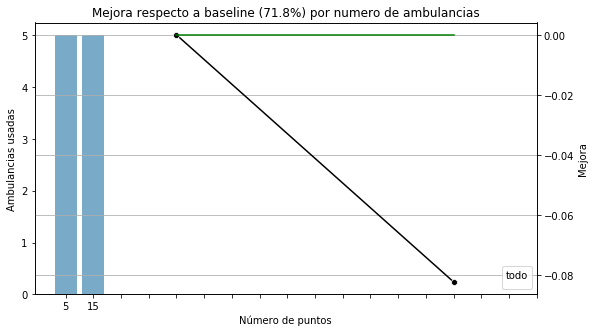

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

for schedule in df_results_enero.schedule.unique():
    print(schedule)
    df_schedule = df_results_enero[(df_results_enero.schedule == schedule)].reset_index(drop=True)

    for ix_amb in range(1, 18):
        agg_d[f'count_amb_{ix_amb}'] = 'sum'
    df_agrup_enero = df_schedule.groupby('n_amb').agg(agg_d).reset_index()
    df_agrup_enero.columns = ['_'.join(col).strip('_') for col in df_agrup_enero.columns]
    df_agrup_enero
    df_agrup_enero['cant_uso_sum'] = 0
    for ix_amb in range(1, 18):
        df_agrup_enero['cant_uso_sum'] += df_agrup_enero[f'count_amb_{ix_amb}_sum'].apply(lambda x: 1 if x > 0 else 0)

    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot(111) 
    ax2 = ax.twinx() 
    pal = sns.color_palette("Blues_r", 1)

    #p1 = sns.lineplot(y='cant_uso_sum', x='n_amb', data=df_agrup_enero, marker='o', ci=80, ax=ax)
    #df_agrup_enero['n_amb'] += 1
    p2 = sns.barplot(y='cant_uso_sum',
                  x='n_amb', data=df_agrup_enero, ci=0, palette=pal, ax=ax) 
    df_schedule['n_amb'] -= 1
    p1 = sns.lineplot(y='mejora', x='n_amb', data=df_schedule, marker='o', ci=80, ax=ax2, color='black')
    p3 = sns.lineplot(y=[0]*df_schedule.n_amb.shape[0], x=df_schedule.n_amb, ax=ax2, color='green')
    

    #p2 = sns.lineplot(y='cant_uso_sum', x='n_amb', data=df_agrup_enero, marker="o", ax=ax2, color='black', ci=0)
    #ax2.margins(0.01)
    #for i in range(df1.shape[0]):
    #        plt.text(i+0.09, 
    #                     df1[y_mean].iloc[i]+0.09,
    #                     str(round(df1[y_mean].iloc[i], 1)) + ' %')

    plt.title(f'Mejora respecto a baseline ({round(df_schedule.baseline.mean()*100, 1)}%) por numero de ambulancias')
    p2.set(xlabel='Número de puntos', ylabel='Ambulancias usadas')
    p3.set(xlabel='', ylabel='Mejora')
    plt.grid()
    legend = plt.legend(handles=[], title=schedule,
                    loc=4, fontsize='medium', fancybox=True)
    p1.set_xticks(np.arange(0,18))
    p2.set_xticks(np.arange(0,18))
    p3.set_xticks(np.arange(0,18))
    plt.show()
        


horario_8pm a 4am


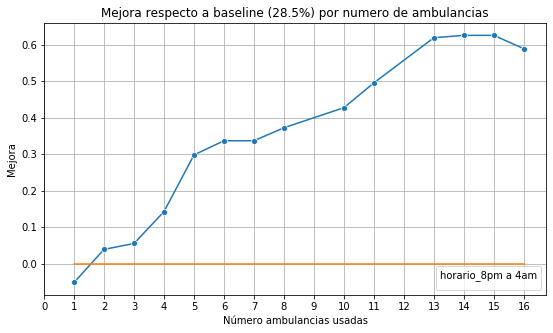

horario_de 4am a 12pm


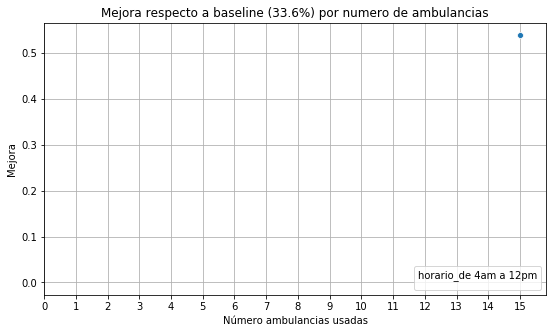

horario_de 12am a 8pm


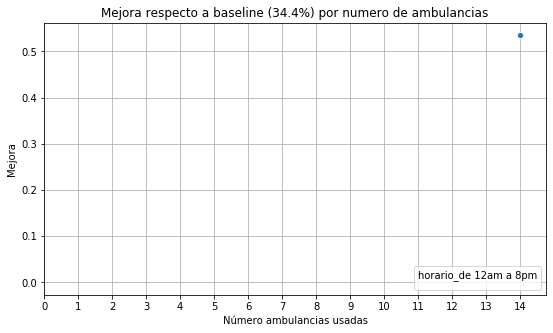

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

for schedule in df_results_enero.schedule.unique():
    print(schedule)
    df_schedule = df_results_enero[(df_results_enero.schedule == schedule)].reset_index(drop=True)

    for ix_amb in range(1, 30):
        agg_d[f'count_amb_{ix_amb}'] = 'sum'
    df_agrup_enero = df_schedule.groupby('n_amb').agg(agg_d).reset_index()
    df_agrup_enero.columns = ['_'.join(col).strip('_') for col in df_agrup_enero.columns]
    df_agrup_enero
    df_agrup_enero['cant_uso_sum'] = 0
    for ix_amb in range(1, 18):
        df_agrup_enero['cant_uso_sum'] += df_agrup_enero[f'count_amb_{ix_amb}_sum'].apply(lambda x: 1 if x > 0 else 0)

    df_agrup_enero = df_agrup_enero.drop_duplicates('cant_uso_sum')
    plt.figure(figsize=(9, 5))
    ax = sns.lineplot(y='mejora_mean', x='cant_uso_sum', data=df_agrup_enero, marker='o', ci=80)
    ax = sns.lineplot(y=[0]*df_agrup_enero.drop_duplicates('cant_uso_sum').cant_uso_sum.shape[0], x=df_agrup_enero.drop_duplicates('cant_uso_sum').cant_uso_sum)
    plt.grid()
    plt.title(f'Mejora respecto a baseline ({round(df_schedule.baseline.mean()*100, 1)}%) por numero de ambulancias')
    ax.set_xlabel('Número ambulancias usadas')
    ax.set_ylabel('Mejora')
    plt.xticks(np.arange(0,df_agrup_enero.cant_uso_sum.max() + 1))
    
    legend = plt.legend(handles=[], title=schedule,
                    loc=4, fontsize='medium', fancybox=True)
    
    plt.show()


horario_8pm a 4am


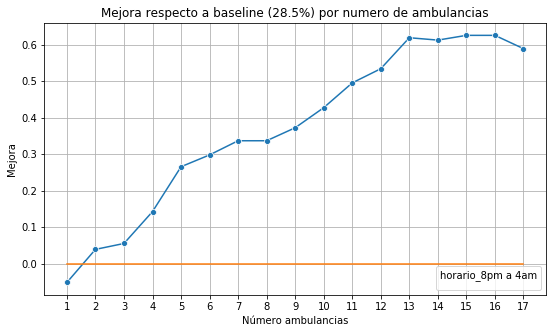

horario_de 4am a 12pm


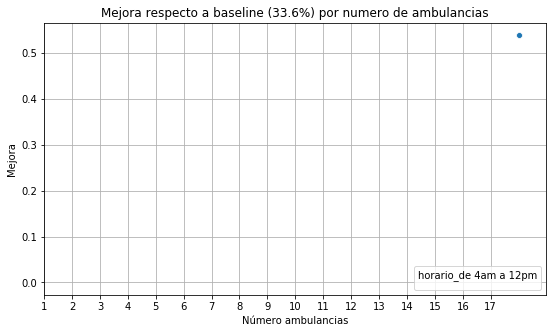

horario_de 12am a 8pm


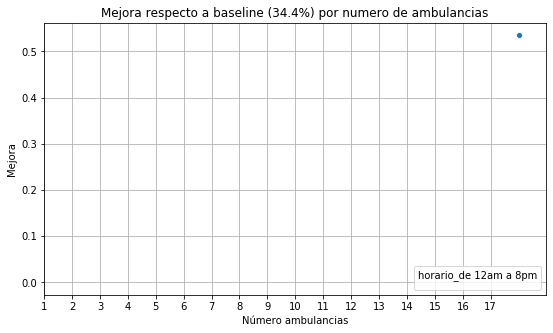

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

for schedule in df_results_enero.schedule.unique():
    print(schedule)
    df_schedule = df_results_enero[(df_results_enero.schedule == schedule) &
                                  (df_results_enero.n_amb < 19) ].reset_index(drop=True)
    plt.figure(figsize=(9, 5))
    ax = sns.lineplot(y='mejora', x='n_amb', data=df_schedule, marker='o', ci=80)
    ax = sns.lineplot(y=[0]*df_schedule.n_amb.shape[0], x=df_schedule.n_amb)
    plt.grid()
    plt.title(f'Mejora respecto a baseline ({round(df_schedule.baseline.mean()*100, 1)}%) por numero de ambulancias')
    ax.set_xlabel('Número ambulancias')
    ax.set_ylabel('Mejora')
    plt.xticks(np.arange(1,18))
    
    legend = plt.legend(handles=[], title=schedule,
                    loc=4, fontsize='medium', fancybox=True)
    
    plt.show()


In [183]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [29]:
temp = []
for cant_amb, horario in [[10, 'horario_8pm a 4am'], 
                          [18, 'horario_de 12am a 8pm'], 
                          [23, 'horario_de 12am a 8pm'],
                          [18, 'horario_de 4am a 12pm']]:
    df_particion = dict_df_atenciones[cant_amb].loc[dict_df_atenciones[cant_amb].horario == horario].sort_values(by='flag_atencion', ascending=False)
    df_particion = df_particion.drop_duplicates('id_sini').reset_index(drop=True)
    #fig, ax = plt.subplots(figsize=(20,20))

    lat_points = []
    lng_points = []
    class_points = []
    for ix, tiempo in enumerate(df_particion['flag_atencion'].unique()):
        print(tiempo)
        df_cut = df_particion.loc[df_particion.flag_atencion == tiempo]
        lat_points += list(df_cut.lat_sini.values)
        lng_points += list(df_cut.lng_sini.values)
        class_points += [tiempo]*df_cut.shape[0]

    df_particion = dict_df_atenciones[cant_amb].loc[dict_df_atenciones[cant_amb].horario == horario].sort_values(by='flag_atencion', ascending=False)
    df_cut = df_particion.drop_duplicates('id_amb')
    df_amb_up = df_cut[df_cut.flag_atencion == 1]
    lat_points += list(df_amb_up.lat_amb.values)
    lng_points += list(df_amb_up.lng_amb.values)
    class_points += [2]*df_amb_up.shape[0]
    
    df_amb_up = df_cut[df_cut.flag_atencion != 1]
    lat_points += list(df_amb_up.lat_amb.values)
    lng_points += list(df_amb_up.lng_amb.values)
    class_points += [3]*df_amb_up.shape[0]

    results = pd.DataFrame()
    results['lat'] = lat_points
    results['lng'] = lng_points
    results['types'] = class_points
    temp.append(results)
    results.to_csv(f'Outputs/data_para_mapas/emerg_new_{cant_amb}_{horario}.csv', index=False)
    

1
0
1
0
1
0
1
0


In [54]:
# 0 - 0 - 0
# 0 - 1 - 1
# 0 - 0 - 2
# 0 - 0 - 3


In [121]:
temp = []
for cant_amb, horario in [[1, 'horario_8pm a 4am']]:
    df_particion = dict_df_atenciones[cant_amb].loc[dict_df_atenciones[cant_amb].horario == horario].sort_values(by='flag_atencion', ascending=False)
    df_particion = df_particion.drop_duplicates('id_sini').reset_index(drop=True)
    #fig, ax = plt.subplots(figsize=(20,20))

    lat_points = []
    lng_points = []
    class_points = []
    for tiempo in df_particion['flag_atencion'].unique():
        print(tiempo)
        df_cut = df_particion.loc[df_particion.flag_atencion == tiempo]
        lat_points += list(df_cut.lat_sini.values)
        lng_points += list(df_cut.lng_sini.values)
        class_points += [tiempo]*df_cut.shape[0]

    df_particion = dict_df_atenciones[cant_amb].loc[dict_df_atenciones[cant_amb].horario == horario].sort_values(by='flag_atencion', ascending=False)
    df_cut = df_particion.drop_duplicates('id_amb')
    df_amb_up = df_cut[df_cut.flag_atencion == 1]
    lat_points += list(df_amb_up.lat_amb.values)
    lng_points += list(df_amb_up.lng_amb.values)
    class_points += [2]*df_amb_up.shape[0]
    
    df_amb_up = df_cut[df_cut.flag_atencion != 1]
    lat_points += list(df_amb_up.lat_amb.values)
    lng_points += list(df_amb_up.lng_amb.values)
    class_points += [3]*df_amb_up.shape[0]

    fig, ax = plt.subplots(figsize=(10,10))
    results = pd.DataFrame()
    results['lat'] = lat_points
    results['lng'] = lng_points
    results['types'] = class_points
    results['geometry'] = [Point(x, y) for x, y in zip(lat_points, lng_points)]
    df_geo = gpd.GeoDataFrame(results, geometry=results['geometry'])
    for ix, color in enumerate(['red', 'green', 'blue', 'black']):

        df_geo.loc[df_geo.types == ix].geometry.plot(ax=ax, color=color, 
                                                 markersize=100,
                                                 label=results['types'].unique()[ix])
    plt.show()

KeyError: 1

In [34]:
df_emerg_filter.head(2)

,numero_del_caso,fecha_hora_de_apertura,dia_de_registro,mes_de_registro,hora_de_registro,fecha_hora_de_cierre,estado,categoria,asunto,tema,especialidad,regularizacion_de_caso,creado_por_nombre_completo,tiempo_de_enfermedad,unidad_de_tiempo,sintomas_principales,tratamiento_previo,diagnostico_presuntivo_cie_10_codigo_cie10,diagnostico_presuntivo_cie_10_nombre_de_cie10,antecedentes_medicos,antecedentes_quirurgicos,prioridad,_requiere_seguimiento_,tratamiento,tipo_de_documento,numero_documento,telefono,nombre_de_la_cuenta_nombre_de_la_cuenta,edad_del_asegurado,titular_de_la_poliza,ramo,producto_poliza,contratante,monto_deducible,propietario_del_caso_nombre_completo,pais_nombre_de_poblacion,provincia_nombre_de_poblacion,distrito_nombre_de_poblacion,departamento_nombre_de_poblacion,anillo,direccion_del_siniestro,telefono_contacto_nombre_de_informacion_de_contacto,referencia_autorizada_,aplica_politica_atencion_o_autorizacion,tipo_de_politica_autorizacion_aplicada,tipo_de_atencion_a_brindar,tipo_consulta_nutricional,responsable_coordinacion_servicio_nombre_completo,proveedor_nombre_de_la_cuenta,...,accion,proveedor_nombre_de_la_cuenta_1,calificacion_del_servicio,fecha_y_hora_de_respuesta,fecha_y_hora_de_consulta,motivo_de_no_asignacion_del_servicio,recuento_caso,zonificacion,grupo_cie10,tiempo_asignacion_de_la_ambulancia_min,intervalos_de_tiempo_asignacion_ambulancia,tiempo_espera_del_asegurado,intervalos_de_tiempo_de_espera_del_asegurado,tiempo_asignacion_mad,intervalos_de_tiempo_asignacion_mad,tiempo_espera_del_asegurado_mad,intervalos_de_tiempo_de_espera_del_asegurado_mad,grupo_colaborador_creador_caso,grupo_colaborador_responsable_caso,solicitud_traslado,cumplimiento_promesa,intervalos_de_tiempo_de_espera_del_asegurado_1,traslado,unnamed_100,direccion_final,formatted_address,lat,lng,geocode_result,unnamed_95,gecode_json,len_geocode,country,state_1,state_2,dist,point,flag_pertenece_limacallao,flag_15,id_sini,cast_fecha_hora,periodo_YMD,tiempo_atencion,cast_datetime,cast_hour,cast_day,cat_schedule,cat_week,cast_weekday
0,15041335,2021-01-01 23:02:00,1,Enero,23:02:00,2021-01-02 05:52:00,Cerrado,Emergencia médica,Unidad médica de emergencia,Atención de emergencia,NaN,No,LADY KAREN CAMACHO MILIAN,1.0,Día,"CAIDA POR LA TARDE, POSTERIOR A ELLO PRESENTO ...",NaN,S635,Esguince y Torcedura de la Muneca,ANT HTA COVID19+ NO CONTACTO COVID19+ NO SOSPE...,-,Media,NO,T4,2.0,15410890,980551130,ELVA MARIA MONTERO VICENTE,79.0,MIRANDA MONTERO ESTHER BENITA,SALUD,AMC COLECTIVA COMPLEMENTARIA,TELEFONICA DEL PERU SAA,NaN,ESPERANZA ADELI MANAY CHAVEZ,PERU,LIMA,PUEBLO LIBRE,LIMA,Centro B,ZARAGOZA 353 DPTO 403,NaN,NaN,No,NaN,Regular,NaN,KATHERINE WENDY MILUSKA TUME ALBINES,MISION MEDICA SAC,...,Envío de Ambulancia,MISION MEDICA SAC,Aceptado,2021-01-01 23:33:00,2021-01-01 23:32:00,NO APLICA,0.0,Central B,otros diagnosticos,00:30:00,h. mayor a 20,01:06:00,g. mayor a 60,00:30:00,b. 30 a 40,01:06:00,a1. 60 a 90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"ZARAGOZA 353 DPTO 403, PUEBLO LIBRE, LIMA","Av. Simón Bolivar 1515, Pueblo Libre 15084, Peru",-12.072503,-77.070841,"[{'address_components': [{'long_name': '1515',...",NaN,"[{'address_components': [{'long_name': '1515',...",8.0,Peru,Municipalidad Metropolitana de Lima,Provincia de Lima,Pueblo Libre,POINT (-77.07084139999999 -12.0725026),True,0,0,2021-01-01 23:02:00,202111,101.0,2021-01-01 23:02:00,23,1,8pm a 4am,0,4
1,15041320,2021-01-01 22:40:00,1,Enero,22:40:00,2021-01-02 08:15:00,Cerrado,Emergencia médica,Unidad médica de emergencia,Atención de emergencia,NaN,No,JACKELIN NOELIA ANTICONA YAURI,1.0,Día,SAT 91%,NIEGA,J960,Insuficiencia respiratoria aguda,COVID POSITIVO NIEGA CONTACTO NIEGA SOSPECHOSO NO,-,Media,NO,T5,2.0,10493487,995713530,FELICITA MEDINA AYALA,80.0,MELGAR CACERES CESAR AUGUSTO,SALUD,PLANES MEDICOS EPS,CONFECCIONES MELGAR S.A,NaN,ESPERANZA ADELI MANAY CHAVEZ,PERU,LIMA,SAN BORJA,LIMA,Centro A,AV. BUENAVISTA 325 DTO. 402,NaN,NaN,NaN,NaN,NaN,NaN,JENNIFER VANESSA GARCIA SOTELO,SERVICIOS MEDICOS PROFESIONALES 

In [34]:
df_emerg_filter[(df_emerg_filter.cat_schedule == '8pm a 4am') & (df_emerg_filter.mes_de_registro == 'Enero')
               ].drop_duplicates('numero_del_caso').intervalos_de_tiempo_de_espera_del_asegurado.value_counts()


a1. menor igual de 15    59
b. 16 a 25               57
d. 31 a 40               40
g. mayor a 60            40
a. menor igual de 8      31
e. 41 a 50               30
c. 26 a 30               21
f. 51 a 60               20
Pendiente                12
Name: intervalos_de_tiempo_de_espera_del_asegurado, dtype: int64

In [449]:
df_emerg_filter.head(1)

,numero_del_caso,fecha_hora_de_apertura,dia_de_registro,mes_de_registro,hora_de_registro,fecha_hora_de_cierre,estado,categoria,asunto,tema,especialidad,regularizacion_de_caso,creado_por_nombre_completo,tiempo_de_enfermedad,unidad_de_tiempo,sintomas_principales,tratamiento_previo,diagnostico_presuntivo_cie_10_codigo_cie10,diagnostico_presuntivo_cie_10_nombre_de_cie10,antecedentes_medicos,antecedentes_quirurgicos,prioridad,_requiere_seguimiento_,tratamiento,tipo_de_documento,numero_documento,telefono,nombre_de_la_cuenta_nombre_de_la_cuenta,edad_del_asegurado,titular_de_la_poliza,ramo,producto_poliza,contratante,monto_deducible,propietario_del_caso_nombre_completo,pais_nombre_de_poblacion,provincia_nombre_de_poblacion,distrito_nombre_de_poblacion,departamento_nombre_de_poblacion,anillo,direccion_del_siniestro,telefono_contacto_nombre_de_informacion_de_contacto,referencia_autorizada_,aplica_politica_atencion_o_autorizacion,tipo_de_politica_autorizacion_aplicada,tipo_de_atencion_a_brindar,tipo_consulta_nutricional,responsable_coordinacion_servicio_nombre_completo,proveedor_nombre_de_la_cuenta,...,accion,proveedor_nombre_de_la_cuenta_1,calificacion_del_servicio,fecha_y_hora_de_respuesta,fecha_y_hora_de_consulta,motivo_de_no_asignacion_del_servicio,recuento_caso,zonificacion,grupo_cie10,tiempo_asignacion_de_la_ambulancia_min,intervalos_de_tiempo_asignacion_ambulancia,tiempo_espera_del_asegurado,intervalos_de_tiempo_de_espera_del_asegurado,tiempo_asignacion_mad,intervalos_de_tiempo_asignacion_mad,tiempo_espera_del_asegurado_mad,intervalos_de_tiempo_de_espera_del_asegurado_mad,grupo_colaborador_creador_caso,grupo_colaborador_responsable_caso,solicitud_traslado,cumplimiento_promesa,intervalos_de_tiempo_de_espera_del_asegurado_1,traslado,unnamed_100,direccion_final,formatted_address,lat,lng,geocode_result,unnamed_95,gecode_json,len_geocode,country,state_1,state_2,dist,point,flag_pertenece_limacallao,flag_8,id_sini,cast_fecha_hora,periodo_YMD,tiempo_atencion,cast_datetime,cast_hour,cast_day,cat_schedule,cat_week,cast_weekday
0,15040690,2021-01-01 12:33:00,1,Enero,12:33:00,2021-01-01 13:28:00,Cerrado,Emergencia médica,Unidad médica de emergencia,Atención código rojo,NaN,No,ANGELIN JOSE ROMERO VALERO,1.0,Día,"MALESTAR GENERAL, AGITADO, DIFICULTAD PARA RES...",NINGUNO,R42X,Mareo y desvanecimiento,¿TIENE PRUEBA COVID19 (+)? ¿TIENE CONTACTO COV...,NO,Media,NO,T3,2.0,07188407,934572050/CONTACTO SEÑOR JUSTO 989217957,LUIS MANUEL EZCURRA MENDOZA,62.0,EZCURRA MENDOZA LUIS MANUEL,SALUD,AMI SALUD RED MEDICA,LUIS MANUELEZCURRA MENDOZA,NaN,ANGELIN JOSE ROMERO VALERO,PERU,LIMA,SANTIAGO DE SURCO,LIMA,Centro A,AV. CALLE JUAN TORRICO 129 DEPTO 201 URB EL DO...,NaN,NaN,NaN,NaN,NaN,NaN,ANGELIN JOSE ROMERO VALERO,SUIZA ALERTA S.A.C.,...,Envío de Ambulancia,SERVICIOS SERVIAL S.A.C.,Aceptado,2021-01-01 12:19:00,2021-01-01 12:19:00,NO APLICA,1.0,Central A,otros diagnosticos,1899-12-30 23:46:00,a. <= a 1,Pendiente,Pendiente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AV. CALLE JUAN TORRICO 129 DEPTO 201 URB EL DO...,"DEPTO 201, Calle Juan Torrico 129, Santiago de...",-12.129418,-76.993151,[{'address_components': [{'long_name': 'DEPTO ...,NaN,[{'address_components': [{'long_name': 'DEPTO ...,9.0,Peru,Municipalidad Metropolitana de Lima,Provincia de Lima,Santiago de Surco,POINT (-76.9931514 -12.1294184),True,b. mayor que 8,0,2021-01-01 12:33:00,202111,NaN,2021-01-01 12:33:00,12,1,de 12am a 8pm,0,4


In [433]:
df_emerg_filter[(df_emerg_filter.lat == -12.0868907) & (df_emerg_filter.lng < -12.08)].drop_duplicates('numero_del_caso')[['id_sini', 'lat', 'lng']]

,id_sini,lat,lng
50,61,-12.086891,-76.958589


In [413]:
r = dict_df_atenciones[cant_amb].loc[dict_df_atenciones[cant_amb].horario == horario]
r[(r.lat_sini > -11.90) & (r.lng_sini < -77)].drop_duplicates('id_sini')

,fecha_hora_culminacion_proveedor,fecha_hora_de_asignacion_al_proveedor,intervalos_de_tiempo_de_espera_del_asegurado,fecha_hora_de_apertura,id_sini,lat_sini,lng_sini,id_amb,lat_amb,lng_amb,Name,Total_TravelTime,Total_Miles,Total_Kilometers,mes_de_registro,tiempo_atencion,numero_del_caso,cast_fecha_hora,periodo_YMD,tiempo_total,margen_tiempo,flag_atencion,horario
0,2021-01-24 14:30:00,2021-01-24 10:52:00,b. 16 a 25,2021-01-24 11:01:00,88,-11.853143,-77.082377,0,-12.10669,-77.043503,Location 1 - Location 2,70.442453,21.011653,33.814978,Enero,218.0,15175809,2021-01-24 11:01:00,2021124,2021-01-24 14:39:00,-1,0,horario_de 4am a 12pm


In [401]:
df_cut[(df_cut.lat_amb > -11.90) & (df_cut.lng_amb < -77)]

,fecha_hora_culminacion_proveedor,fecha_hora_de_asignacion_al_proveedor,intervalos_de_tiempo_de_espera_del_asegurado,fecha_hora_de_apertura,id_sini,lat_sini,lng_sini,id_amb,lat_amb,lng_amb,Name,Total_TravelTime,Total_Miles,Total_Kilometers,mes_de_registro,tiempo_atencion,numero_del_caso,cast_fecha_hora,periodo_YMD,tiempo_total,margen_tiempo,flag_atencion,horario
8,2021-01-25 12:45:00,2021-01-25 10:45:00,c. 26 a 30,2021-01-25 11:02:00,92,-12.055991,-77.134412,8,-11.878273,-77.126587,Location 1 - Location 2,30.499251,13.28311,21.377093,Enero,120.0,15178930,2021-01-25 11:02:00,2021125,2021-01-25 13:02:00,-1,0,horario_de 4am a 12pm


In [402]:
df_cut[(df_cut.lat_sini > -12) & (df_cut.lng_sini < -76.95)]

,fecha_hora_culminacion_proveedor,fecha_hora_de_asignacion_al_proveedor,intervalos_de_tiempo_de_espera_del_asegurado,fecha_hora_de_apertura,id_sini,lat_sini,lng_sini,id_amb,lat_amb,lng_amb,Name,Total_TravelTime,Total_Miles,Total_Kilometers,mes_de_registro,tiempo_atencion,numero_del_caso,cast_fecha_hora,periodo_YMD,tiempo_total,margen_tiempo,flag_atencion,horario
46,2021-01-28 14:31:00,2021-01-28 10:59:00,c. 26 a 30,2021-01-28 10:46:00,108,-11.996886,-77.076216,11,-11.988445,-77.082168,Location 1 - Location 2,5.379642,1.373461,2.210371,Enero,212.0,15201008,2021-01-28 10:46:00,2021128,2021-01-28 14:18:00,1,1,horario_de 4am a 12pm
40,2021-01-24 14:30:00,2021-01-24 10:52:00,b. 16 a 25,2021-01-24 11:01:00,88,-11.853143,-77.082377,20,-12.176349,-77.010372,Location 1 - Location 2,80.479473,25.162269,40.494747,Enero,218.0,15175809,2021-01-24 11:01:00,2021124,2021-01-24 14:39:00,-1,0,horario_de 4am a 12pm


In [333]:
df_emerg_filter[(df_emerg_filter.lat < -12) & (df_emerg_filter.lng < -76.95) & (df_emerg_filter.lng > -76.96)
                & (df_emerg_filter.cat_schedule == 'de 4am a 12pm')].sort_values(by='recuento_caso').drop_duplicates(['numero_del_caso']).shape


(307, 127)

In [390]:
df_emerg_filter[(df_emerg_filter.lat < -12) & (df_emerg_filter.lng < -76.95) & (df_emerg_filter.lng > -76.96)
                & (df_emerg_filter.cat_schedule == 'de 4am a 12pm')][['id_sini']]

,id_sini
50,61


In [334]:
df_emerg_filter.shape

(383, 127)

In [ ]:
['green', 'red', 'blue', 'black']

In [265]:
sorted(df_particion.drop_duplicates('id_amb').id_amb.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [150]:
dict_df_atenciones[10].head(1)

,fecha_hora_culminacion_proveedor,fecha_hora_de_asignacion_al_proveedor,intervalos_de_tiempo_de_espera_del_asegurado,fecha_hora_de_apertura,id_sini,lat_sini,lng_sini,id_amb,lat_amb,lng_amb,Name,Total_TravelTime,Total_Miles,Total_Kilometers,mes_de_registro,tiempo_atencion,cast_fecha_hora,periodo_YMD,tiempo_total,margen_tiempo,flag_atencion,horario
0,2021-01-01 02:40:00,2021-01-01 01:36:00,d. 31 a 40,2021-01-01 01:32:00,3,-12.057099,-77.107401,0,-12.086555,-77.064184,Location 1 - Location 2,15.845952,4.599604,7.402345,Enero,64.0,2021-01-01 01:32:00,202111,2021-01-01 02:36:00,1.0,0,horario_8pm a 4am


In [164]:
temp[1].head()

,lat,lng,types
0,-12.116593,-77.045303,0
1,-12.112194,-77.033347,0
2,-12.116302,-76.994348,0
3,-12.128536,-77.024758,0
4,-12.141991,-77.000976,0


In [165]:
temp[2].head()

,lat,lng,types
0,-12.129418,-76.993151,0
1,-12.118016,-76.983346,0
2,-12.119293,-77.017533,0
3,-12.170712,-76.992464,0
4,-12.124921,-76.977945,0


(61, 3)

In [132]:
results.head()

,lat,lng,types
0,-12.144822,-77.014441,0
1,-12.057099,-77.107401,0
2,-11.953035,-77.070105,0
3,-12.087244,-77.036127,0
4,-12.119293,-77.017533,0


In [112]:
dict_df_atenciones.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

In [176]:
results['types'].value_counts()

1    26
0    26
2     9
Name: types, dtype: int64

In [149]:
df_geo.head()

,geometry,types
0,POINT (-12.12942 -76.99315),0
1,POINT (-12.12942 -76.99315),0
2,POINT (-12.12942 -76.99315),0
3,POINT (-12.12942 -76.99315),0
4,POINT (-12.12942 -76.99315),0


In [259]:
dict_df_atenciones[10].query("horario=='horario_8pm a 4am'").query("")['Total_TravelTime'].mean()

,fecha_hora_culminacion_proveedor,fecha_hora_de_asignacion_al_proveedor,intervalos_de_tiempo_de_espera_del_asegurado,fecha_hora_de_apertura,id_sini,lat_sini,lng_sini,id_amb,lat_amb,lng_amb,Name,Total_TravelTime,Total_Miles,Total_Kilometers,mes_de_registro,tiempo_atencion,cast_fecha_hora,periodo_YMD,tiempo_total,margen_tiempo,flag_atencion,horario
0,2021-01-01 02:40:00,2021-01-01 01:36:00,d. 31 a 40,2021-01-01 01:32:00,3,-12.057099,-77.107401,0,-12.086555,-77.064184,Location 1 - Location 2,15.845952,4.599604,7.402345,Enero,64.0,2021-01-01 01:32:00,202111,2021-01-01 02:36:00,1.0,0,horario_8pm a 4am
1,2021-01-01 02:40:00,2021-01-01 01:36:00,d. 31 a 40,2021-01-01 01:32:00,376,-12.057099,-77.107401,0,-12.086555,-77.064184,Location 1 - Location 2,15.845952,4.599604,7.402345,Enero,64.0,2021-01-01 01:32:00,202111,2021-01-01 02:36:00,-3840.0,0,horario_8pm a 4am
2,2021-01-01 02:23:00,2021-01-01 01:25:00,b. 16 a 25,2021-01-01 01:33:00,2,-12.070429,-77.100398,0,-12.086555,-77.064184,Location 1 - Location 2,12.034406,3.334726,5.366721,Enero,58.0,2021-01-01 01:33:00,202111,2021-01-01 02:31:00,-3780.0,0,horario_8pm a 4am
3,2021-01-01 02:23:00,2021-01-01 01:25:00,b. 16 a 25,2021-01-01 01:33:00,377,-12.070429,-77.100398,0,-12.086555,-77.064184,Location 1 - Location 2,12.034406,3.334726,5.366721,Enero,58.0,2021-01-01 01:33:00,202111,2021-01-01 02:31:00,-3780.0,0,horario_8pm a 4am
4,2021-01-01 02:40:00,2021-01-01 01:36:00,d. 31 a 40,2021-01-01 01:32:00,3,-12.057099,-77.107401,1,-12.112934,-76.988000,Location 1 - Location 2,41.653348,10.994070,17.693241,Enero,64.0,2021-01-01 01:32:00,202111,2021-01-01 02:36:00,1.0,0,horario_8pm a 4am
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2021-01-31 01:57:00,2021-01-31 01:12:00,a1. menor igual de 15,2021-01-31 01:17:00,131,-12.075372,-76.990474,5,-12.211623,-76.941213,Location 1 - Location 2,34.423459,12.300026,19.794973,Enero,45.0,2021-01-31 01:17:00,2021131,2021-01-31 02:02:00,1.0,0,horario_8pm a 4am
6,2021-01-31 01:57:00,2021-01-31 01:12:00,a1. menor igual de 15,2021-01-31 01:17:00,131,-12.075372,-76.990474,6,-12.105428,-76.934659,Location 1 - Location 2,24.771953,6.890711,11.089524,Enero,45.0,2021-01-31 01:17:00,2021131,2021-01-31 02:02:00,1.0,0,horario_8pm a 4am
7,2021-01-31 01:57:00,2021-01-31 01:12:00,a1. menor igual de 15,2021-01-31 01:17:00,131,-12.075372,-76.990474,7,-12.142649,-77.014959,Location 1 - Location 2,24.999719,8.352839,13.442591,Enero,45.0,2021-01-31 01:17:00,2021131,2021-01-31 02:02:00,1.0,0,horario_8pm a 4am
8,2021-01-31 01:57:00,2021-01-31 01:12:00,a1. menor igual de 15,2021-01-31 01:17:00,131,-12.075372,-76.990474,8,-12.070991,-77.103860,Location 1 - Location 2,36.787154,10.604983,17.067066,Enero,45.0,2021-01-31 01:17:00,2021131,2021-01-31 02:02:00,1.0,0,horario_8pm a 4am
